In [ ]:
# Correr todo hasta antes de "Ejemplo de prueba sobre 20 imágenes comparativa (semáforo = 5)", y luego saltarse todo
# hasta la sección "CONCURRENTE", de ahí saltar a "CON PROMPT MÁS ELEBORADO:"

In [1]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 13.1 MB/s eta 0:

In [2]:
# ———————— Librerías estándar ————————
import os
import io
import time
import asyncio

# ———————— Data y visualización ————————
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image as PILImage

# ———————— Google Cloud / Vertex AI ————————
from google.cloud import storage
from google import genai
import vertexai
from vertexai.preview.vision_models import Image as VertexImage

# ———————— Base de datos Embeddings ————————
import chromadb
from chromadb.config import Settings

# ———————— Métricas de ML ————————
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# ———————— Helpers de notebook ————————
from IPython.display import HTML, Markdown, display

## **Carga y preprocesamiento de imágenes MHIST desde un bucket de GCS**
Este bloque configura el acceso a un bucket de Google Cloud Storage, descarga el archivo CSV de anotaciones y lo carga en un DataFrame de pandas.
Luego crea la columna binaria **`y`** indicando con 1 las muestras etiquetadas como “SSA” y con 0 las demás.

In [3]:
# 1) Parámetros de tu bucket
BUCKET_NAME    = "datasets_biomed_llm"
PREFIX_IMAGES  = "MHIST/"         # carpeta en el bucket
PREFIX_CSV     = "MHIST/annotations_train_val_test.csv" # ruta dentro del bucket

# 2) Inicializa el cliente de GCS
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

# 3) Descarga y carga el CSV de anotaciones
blob_csv = bucket.blob(PREFIX_CSV)
data_csv = blob_csv.download_as_bytes()
df = pd.read_csv(io.BytesIO(data_csv))

# 4) Procesa la etiqueta binaria
df["y"] = (df["Majority Vote Label"] == "SSA").astype(int)

In [4]:
df

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aaa.png,SSA,6,train,1
1,MHIST_aab.png,HP,0,train,0
2,MHIST_aac.png,SSA,5,train,1
3,MHIST_aae.png,HP,1,train,0
4,MHIST_aaf.png,SSA,5,train,1
...,...,...,...,...,...
3147,MHIST_cpn.png,SSA,7,val,1
3148,MHIST_cfc.png,SSA,7,test,1
3149,MHIST_cgp.png,SSA,7,test,1
3150,MHIST_dlf.png,SSA,7,train,1


In [5]:
# DataFrame de entrenamiento
train_df = df[df["Partition"] == "train"].reset_index(drop=True)

# DataFrame de entrenamiento
val_df = df[df["Partition"] == "val"].reset_index(drop=True)

# DataFrame de prueba
test_df  = df[df["Partition"] == "test"].reset_index(drop=True)

In [6]:
train_df

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aaa.png,SSA,6,train,1
1,MHIST_aab.png,HP,0,train,0
2,MHIST_aac.png,SSA,5,train,1
3,MHIST_aae.png,HP,1,train,0
4,MHIST_aaf.png,SSA,5,train,1
...,...,...,...,...,...
1735,MHIST_bxr.png,SSA,7,train,1
1736,MHIST_bub.png,SSA,7,train,1
1737,MHIST_bvy.png,SSA,7,train,1
1738,MHIST_dlf.png,SSA,7,train,1


In [7]:
val_df

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aai.png,HP,3,val,0
1,MHIST_aam.png,HP,0,val,0
2,MHIST_aas.png,SSA,4,val,1
3,MHIST_aat.png,HP,0,val,0
4,MHIST_aaw.png,HP,0,val,0
...,...,...,...,...,...
430,MHIST_bxq.png,SSA,7,val,1
431,MHIST_cja.png,SSA,7,val,1
432,MHIST_eeh.png,SSA,7,val,1
433,MHIST_bcy.png,SSA,7,val,1


In [8]:
test_df

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aag.png,HP,2,test,0
1,MHIST_aah.png,HP,2,test,0
2,MHIST_aaq.png,SSA,5,test,1
3,MHIST_aar.png,HP,0,test,0
4,MHIST_aay.png,HP,1,test,0
...,...,...,...,...,...
972,MHIST_eqz.png,SSA,7,test,1
973,MHIST_edm.png,SSA,7,test,1
974,MHIST_blw.png,SSA,7,test,1
975,MHIST_cfc.png,SSA,7,test,1


La siguiente función itera sobre un DataFrame, descarga cada imagen desde el bucket, la convierte y redimensiona, y finalmente devuelve dos listas con los objetos `VertexImage` y sus etiquetas correspondientes.

In [9]:
# La función process_mhist_df_images toma un DataFrame
# con nombres de archivo y etiquetas binarias, junto con
# un bucket de Google Cloud Storage y un prefijo de ruta de anotaciones;
# recorre cada fila descargando la imagen remota, la convierte a RGB,
# la redimensiona a 224×224 píxeles con PIL, la guarda temporalmente
# y la carga como un objeto VertexImage preparado para la API de Vertex AI;
# finalmente acumula estas instancias junto con sus etiquetas enteras
# y devuelve dos listas: una de imágenes y otra de las etiquetas correspondientes.fvvfv

def process_mhist_df_images(df, bucket, prefix):
    """
    Dado un DataFrame `df` con columnas:
      - "Image Name" (p.ej. "MHIST_aab.png")
      - "y"          (etiqueta binaria)
    y un bucket de GCS con prefijo `prefix`,
    descarga cada imagen, la convierte en un objeto
    VertexImage (listo para get_embeddings) y devuelve:
      - images: list de VertexImage
      - labels: list de etiquetas (enteras)
    """
    images = []
    labels = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_name = row["Image Name"]
        # 1) descarga bytes
        img_bytes = bucket.blob(prefix + img_name).download_as_bytes()
        # 2) abre y redimensiona con PIL
        pil_img = (
            PILImage.open(io.BytesIO(img_bytes))
                    .convert("RGB")
                    .resize((224, 224))
        )
        # 3) guarda a disco y carga como VertexImage
        tmp_path = f"/tmp/{img_name}"
        pil_img.save(tmp_path)
        vm_image = VertexImage.load_from_file(tmp_path)

        images.append(vm_image)
        labels.append(int(row["y"]))

    return images, labels

100%|██████████| 977/977 [03:14<00:00,  5.02it/s]


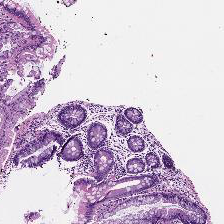

Etiqueta: 0


In [10]:
# SE EJECUTA EN 3 MINUTOS (SOLO IMÁGENES DE TEST)
# 1) Usa la función adaptada para MHIST (que devuelve VertexImage y etiquetas)
images_vm, labels = process_mhist_df_images(test_df, bucket, PREFIX_IMAGES)

# 2) Para visualizar, volvemos a abrir la primera imagen con PIL
first_name = test_df.loc[0, "Image Name"]
img_bytes  = bucket.blob(PREFIX_IMAGES + first_name).download_as_bytes()
pil_img    = PILImage.open(io.BytesIO(img_bytes))

# 3) Mostramos la imagen y la etiqueta
display(pil_img)   # o: pil_img.show()
print("Etiqueta:", labels[0])

In [11]:
# CORRER ESTA CELDA
# Este bloque prepara y autentica el cliente GenAI para usar Vertex AI
# (o bien la API de Gemini en “modo express” si no hay acceso completo),
# mostrando el proyecto, región o clave API que está usando.

PROJECT_ID = "[your-project-id]"
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

if not client.vertexai:
    print(f"Using Gemini Developer API.")
elif client._api_client.project:
    print(
        f"Using Vertex AI with project: {client._api_client.project} in location: {client._api_client.location}"
    )
elif client._api_client.api_key:
    print(
        f"Using Vertex AI in express mode with API key: {client._api_client.api_key[:5]}...{client._api_client.api_key[-5:]}"
    )

Using Vertex AI with project: llms-for-biomed in location: us-central1


In [12]:
# CORRER ESTA CELDA
MODEL_ID = "gemini-2.0-flash"
#MODEL_ID = "gemini-1.5-pro"
#MODEL_ID = "gemini-2.5-pro-exp-03-25"
#response = client.models.generate_content(
#    model=MODEL_ID, contents="What's the largest planet in our solar system?"
#)

#display(Markdown(response.text))

Si se quiere describir la primera imagen del conjunto de test con gemini:

In [ ]:
# Describe the first image of test set
# image = images_vm[0]
# image_pil = images_vm[0]._pil_image
# response = client.models.generate_content(
#                   model=MODEL_ID, contents=["Describe the image", image_pil])
# display(Markdown(response.text))

# **Función para llamados concurrentes**

In [ ]:
# 1) Crea un semáforo que permita hasta 5 peticiones simultáneas
# sem = asyncio.Semaphore(20)

Hacer experimento con un prompt sencillo y con un prompt más elaborado.

In [ ]:
# IMPORTANTE: CON PROMPT SENCILLO
# async def classify_image_async(image_data, semaphore: asyncio.Semaphore, request_timeout: int = 60) -> int:
#     """
#     Classify an image with Gemini/Vertex AI in a pseudo-async way (to_thread).
#     Return 1 for SSA, 0 para HP.
#     """
#     prompt = (
#         "You are an expert medical AI assistant trained in histopathology."
#         "Analyze the microscopic image of colon tissue and capture some features."
#         "Based on these features, classify the image's tissue as either 'SSA' (Sessile Serrated Adenoma) or 'HP' (Healthy Polyp)."
#     )

#     async with semaphore:
#         try:
#             response = await asyncio.wait_for(
#                 asyncio.to_thread(
#                     lambda: client.models.generate_content(
#                         model=MODEL_ID,
#                         contents=[prompt, image_data._pil_image]
#                     )
#                 ),
#                 timeout=request_timeout
#             )

#         except asyncio.TimeoutError:
#             print(f"⚠️ Timeout tras {request_timeout}s en imagen {getattr(image_data,'_marker',image_data)}")
#             return -1

#         except Exception as e:
#             # Aquí puedes loguear e imprimir e, si quieres:
#             print(f"⚠️ Error clasificado imagen: {e}")
#             return -1

#     text = (response.text or "").strip().upper()#(response.text or "").strip().lower()
#     return 1 if "SSA" in text else 0

# # 1) Asegúrate de tener el semáforo definido
# sem = asyncio.Semaphore(5)

# # 2) Escoge la imagen
# test_index = 399
# test_image = images_vm[test_index]

# # 3) Llama con await
# predicted_label = await classify_image_async(test_image, sem, request_timeout=60)
# print("Etiqueta predicha:", predicted_label, "-- Etiqueta real:", labels[test_index])


# # describe the image
# image_pil = test_image._pil_image
# response = client.models.generate_content(
#                   model=MODEL_ID, contents=["Describe the image", image_pil])
# display(Markdown(response.text))

## **Evaluación en múltiples corridas**

## **CONCURRENTE:**

### **CON PROMPT SENCILLO (NO INTERESA):**  
prompt = (  
        "You are an expert medical AI assistant trained in histopathology."  
        "Analyze the microscopic image of colon tissue and capture some features."  
        "Based on these features, classify the tissue as either 'SSA' (Sessile Serrated Adenoma) or 'HP' (Healthy Polyp)."  
    )

In [ ]:
async def classify_image_async(image_data, semaphore: asyncio.Semaphore, request_timeout: int = 60) -> int:
    """
    Classify an image with Gemini/Vertex AI in a pseudo-async way (to_thread).
    Return 1 for SSA, 0 para HP.
    """
    prompt = (
        "You are an expert medical AI assistant trained in histopathology."
        "Analyze the microscopic image of colon tissue and capture some features."
        "Based on these features, classify the image's tissue as either 'SSA' (Sessile Serrated Adenoma) or 'HP' (Healthy Polyp)."
    )

    async with semaphore:
        try:
            response = await asyncio.wait_for(
                asyncio.to_thread(
                    lambda: client.models.generate_content(
                        model=MODEL_ID,
                        contents=[prompt, image_data._pil_image]
                    )
                ),
                timeout=request_timeout
            )

        except asyncio.TimeoutError:
            print(f"⚠️ Timeout tras {request_timeout}s en imagen {getattr(image_data,'_marker',image_data)}")
            return -1

        except Exception as e:
            # Aquí puedes loguear e imprimir e, si quieres:
            print(f"⚠️ Error clasificado imagen: {e}")
            return -1

    text = (response.text or "").strip().upper()#(response.text or "").strip().lower()
    return 1 if "SSA" in text else 0

**NO VOLVER A EJECUTAR, PREDICCIONES GUARDADAS, EJECUTAR CELDA SIGUIENTE:**

In [ ]:
# CLIENTE DE GENAI Y MODEL_ID ACTIVOS
# Carpeta donde guardaremos los experimentos de este notebook:
BASE_EXPERIMENTS_PATH = f"{PREFIX_IMAGES}Experimentos/Baseline_zero_shots_MHIST"

# 0) Semáforo global para limitar concurrencia
sem = asyncio.Semaphore(30)

# 1) Reutilizamos classify_image_async y definimos un helper para un batch
async def classify_batch(images, timeout=60):
    coros = [
        classify_image_async(img, sem, request_timeout=timeout)
        for img in images
    ]
    results = []
    for coro in tqdm(asyncio.as_completed(coros),
                     total=len(coros),
                     desc="Clasificando"):
        results.append(await coro)
    return results

# 2) Versión asíncrona de los experimentos
async def run_gemini_experiments_async(images, true_labels, n_runs=5):
    records = []
    y_test = np.array(true_labels)

    for run in range(1, n_runs+1):
        # 2.1) Clasificación completa en paralelo
        start = time.time()
        y_pred = await classify_batch(images, timeout=60)
        elapsed = time.time() - start

        # 2.2) Como classify_image_async solo devuelve int,
        #      usamos un array de NaNs para scores continuos
        y_pred  = np.array(y_pred, dtype=int)
        y_score = np.full_like(y_pred, np.nan, dtype=float)

        # 2.3) Cálculo de métricas
        mask           = (y_pred != -1)
        y_test_valid   = y_test[mask]
        y_pred_valid   = y_pred[mask]


        # ===> AÑADIR GUARDADO DE LAS PREDICCIONES EN CSV <===
        # 1) Crear un DataFrame solo con las etiquetas predichas
        df_preds = pd.DataFrame({
            "run": run,
            "index_imagen": np.arange(len(y_pred_valid)),
            "y_pred": y_pred_valid,
            "y_true": y_test_valid
        })
        # 2) # En lugar de guardar localmente, subimos directamente a GCS:
        # client = storage.Client()
        # bucket = client.bucket(BUCKET_NAME)
        blob = bucket.blob(f"{BASE_EXPERIMENTS_PATH}/EasyPrompt/predictions_run_{run}.csv")
        blob.upload_from_string(
            df_preds.to_csv(index=False),
            content_type="text/csv"
        )
        # ================================================



        if len(y_pred_valid) == 0:
            # Si todas las imágenes fallaron, registra NaN y continúa
            acc = prec = rec = f1 = np.nan
            cm  = np.array([[0, 0], [0, 0]])
        else:
            acc  = accuracy_score( y_test_valid, y_pred_valid )
            prec = precision_score(y_test_valid, y_pred_valid, zero_division=0)
            rec  = recall_score(   y_test_valid, y_pred_valid, zero_division=0)
            f1   = f1_score(       y_test_valid, y_pred_valid, zero_division=0)
            cm   = confusion_matrix(y_test_valid, y_pred_valid, labels=[0, 1])

        records.append({
            "run":       run,
            "accuracy":  acc,
            "precision": prec,
            "recall":    rec,
            "f1":        f1,
            "tn":        int(cm[0,0]),
            "fp":        int(cm[0,1]),
            "fn":        int(cm[1,0]),
            "tp":        int(cm[1,1]),
            "time_s":    elapsed
        })

    df = pd.DataFrame(records)
    df.index.name = "index"
    return df

# 3) Ejecutar y mostrar resultados
#    En un notebook Jupyter/Colab debes usar "await" en la raíz
n_runs = 5
df_gemini_results = await run_gemini_experiments_async(images_vm, labels, n_runs=n_runs)
df_gemini_results

Clasificando: 100%|██████████| 977/977 [06:08<00:00,  2.65it/s]


,run,accuracy,precision,recall,f1,tn,fp,fn,tp,time_s
index,,,,,,,,,,
0,1,0.370522,0.368962,0.997222,0.538635,3,614,1,359,395.983643
1,2,0.371546,0.369610,1.000000,0.539730,3,614,0,360,390.046133
2,3,0.371546,0.368530,0.988889,0.536953,7,610,4,356,377.893933
3,4,0.372569,0.369722,0.997222,0.539444,5,612,1,359,371.476580
4,5,0.370522,0.369231,1.000000,0.539326,2,615,0,360,368.745045


Calcular métricas de experimentos ya corridos:


In [ ]:
# ------- Carga de etiquetas verdaderas (labels) -------
# Supongamos que ya tienes "labels" en memoria como lista o array de int:

BUCKET_NAME    = "datasets_biomed_llm"
PREFIX_IMAGES  = "MHIST/"         # carpeta en el bucket

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

BASE_EXPERIMENTS_PATH = f"{PREFIX_IMAGES}Experimentos/Baseline_zero_shots_MHIST"

# ------- Número de corridas que guardaste (n_runs) -------
n_runs = 5

# ------- Lista para almacenar resultados de cada corrida -------
registros = []

for run in range(1, n_runs + 1):
    # 1) Leer el CSV de predicciones de la corrida actual desde el bucket
    blob_path = f"{BASE_EXPERIMENTS_PATH}/EasyPrompt/predictions_run_{run}.csv"
    blob = bucket.blob(blob_path)
    csv_str = blob.download_as_text()

    # ------ Corrección: usar io.StringIO en lugar de pd.compat.StringIO ------
    df_preds = pd.read_csv(io.StringIO(csv_str))

    # 2) Extraer vector de predicciones (suponemos columna "y_pred")
    y_pred = df_preds["y_pred"].to_numpy(dtype=int)
    y_test = df_preds["y_true"].to_numpy(dtype=int)

    # 3) Calcular métricas
    if len(y_pred) == 0:
        acc = prec = rec = f1 = np.nan
        cm = np.array([[0, 0], [0, 0]])
    else:
        acc  = accuracy_score( y_test, y_pred )
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(   y_test, y_pred, zero_division=0)
        f1   = f1_score(       y_test, y_pred, zero_division=0)
        cm   = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # 4) Guardar resultados en la lista
    registros.append({
        "run":       run,
        "accuracy":  acc,
        "precision": prec,
        "recall":    rec,
        "f1":        f1,
        "tn":        int(cm[0,0]),
        "fp":        int(cm[0,1]),
        "fn":        int(cm[1,0]),
        "tp":        int(cm[1,1]),
        "n_total":   len(y_pred)
    })

# ------- Construir DataFrame final con todas las métricas -------
df_resultados = pd.DataFrame(registros)
df_resultados.index.name = "index"

# Mostrar resultados
df_resultados

,run,accuracy,precision,recall,f1,tn,fp,fn,tp,n_total
index,,,,,,,,,,
0,1,0.370522,0.368962,0.997222,0.538635,3,614,1,359,977
1,2,0.371546,0.369610,1.000000,0.539730,3,614,0,360,977
2,3,0.371546,0.368530,0.988889,0.536953,7,610,4,356,977
3,4,0.372569,0.369722,0.997222,0.539444,5,612,1,359,977
4,5,0.370522,0.369231,1.000000,0.539326,2,615,0,360,977


### **CON PROMPT MÁS ELEBORADO:**   
prompt = (  
        "You are an expert medical AI assistant trained in histopathology."  
        "Analyze the following microscopic image of colon tissue."  
        "Your task focuses on the clinically-important binary distinction between HPs and SSAs."  
        "HPs are typically benign, while sessile serrated adenomas (SSAs) are precancerous lesions that can turn into cancer if left untreated and require sooner follow-up examinations"  
        "Look for key features such as crypt distortion, goblet cell mucin depletion, branching crypts, and serrated architecture."  
        "Based on these features, classify the tissue as either 'SSA' (Sessile Serrated Adenoma) or 'HP' (Healthy Polyp)."  
    )

In [13]:
async def classify_image_async_1(image_data, semaphore: asyncio.Semaphore, request_timeout: int = 60) -> int:
    """
    Classify an image with Gemini/Vertex AI in a pseudo-async way (to_thread).
    Return 1 for SSA, 0 para HP.
    """
    prompt = (
        """You are an expert medical AI assistant trained in histopathology.
           Your task is to analyze microscopic images of colon tissue and classify them as either
           'SSA' (Sessile Serrated Adenoma) or 'HP' (Healthy Polyp).
           HPs are typically benign, while sessile serrated adenomas (SSAs) are precancerous
           lesions that can turn into cancer if left untreated and require sooner follow-up examinations."""
    )

    async with semaphore:
        try:
            response = await asyncio.wait_for(
                asyncio.to_thread(
                    lambda: client.models.generate_content(
                        model=MODEL_ID,
                        contents=[prompt, image_data._pil_image]
                    )
                ),
                timeout=request_timeout
            )

        except asyncio.TimeoutError:
            print(f"⚠️ Timeout tras {request_timeout}s en imagen {getattr(image_data,'_marker',image_data)}")
            return -1

        except Exception as e:
            # Aquí puedes loguear e imprimir e, si quieres:
            print(f"⚠️ Error clasificado imagen: {e}")
            return -1

    text = (response.text or "").strip().upper()#(response.text or "").strip().lower()
    return 1 if "SSA" in text else 0

**NO VOLVER A EJECUTAR, PREDICCIONES GUARDADAS, EJECUTAR CELDA SIGUIENTE:**

In [14]:
# CLIENTE DE GENAI Y MODEL_ID ACTIVOS
# 0) Semáforo global para limitar concurrencia
BASE_EXPERIMENTS_PATH = f"{PREFIX_IMAGES}Experimentos/Baseline_zero_shots_MHIST"
sem = asyncio.Semaphore(30)

async def classify_batch(images, timeout=60):
    coros = [
        classify_image_async_1(img, sem, request_timeout=timeout)
        for img in images
    ]
    results = []
    for coro in tqdm(asyncio.as_completed(coros),
                     total=len(coros),
                     desc="Clasificando"):
        results.append(await coro)
    return results

# 2) Versión asíncrona de los experimentos
async def run_gemini_experiments_async(images, true_labels, n_runs=5):
    records = []
    y_test = np.array(true_labels)

    for run in range(1, n_runs+1):
        # 2.1) Clasificación completa en paralelo
        start = time.time()
        y_pred = await classify_batch(images, timeout=60)
        elapsed = time.time() - start

        # 2.2) Como classify_image_async solo devuelve int,
        #      usamos un array de NaNs para scores continuos
        y_pred  = np.array(y_pred, dtype=int)
        y_score = np.full_like(y_pred, np.nan, dtype=float)

        # 2.3) Cálculo de métricas
        mask           = (y_pred != -1)
        y_test_valid   = y_test[mask]
        y_pred_valid   = y_pred[mask]

        # ===> AÑADIR GUARDADO DE LAS PREDICCIONES EN CSV <===
        # 1) Crear un DataFrame solo con las etiquetas predichas
        df_preds = pd.DataFrame({
            "run": run,
            "index_imagen": np.arange(len(y_pred_valid)),
            "y_pred": y_pred_valid,
            "y_true": y_test_valid
        })
        # 2) # En lugar de guardar localmente, subimos directamente a GCS:
        # client = storage.Client()
        # bucket = client.bucket(BUCKET_NAME)
        blob = bucket.blob(f"{BASE_EXPERIMENTS_PATH}/HardPrompt/predictions_run_{run}.csv")
        blob.upload_from_string(
            df_preds.to_csv(index=False),
            content_type="text/csv"
        )
        # ================================================

        if len(y_pred_valid) == 0:
            # Si todas las imágenes fallaron, registra NaN y continúa
            acc = prec = rec = f1 = np.nan
            cm  = np.array([[0, 0], [0, 0]])
        else:
            acc  = accuracy_score( y_test_valid, y_pred_valid )
            prec = precision_score(y_test_valid, y_pred_valid, zero_division=0)
            rec  = recall_score(   y_test_valid, y_pred_valid, zero_division=0)
            f1   = f1_score(       y_test_valid, y_pred_valid, zero_division=0)
            cm   = confusion_matrix(y_test_valid, y_pred_valid, labels=[0, 1])

        records.append({
            "run":       run,
            "accuracy":  acc,
            "precision": prec,
            "recall":    rec,
            "f1":        f1,
            "tn":        int(cm[0,0]),
            "fp":        int(cm[0,1]),
            "fn":        int(cm[1,0]),
            "tp":        int(cm[1,1]),
            "time_s":    elapsed
        })

    df = pd.DataFrame(records)
    df.index.name = "index"
    return df

# 3) Ejecutar y mostrar resultados
#    En un notebook Jupyter/Colab debes usar "await" en la raíz
n_runs = 5
df_gemini_results = await run_gemini_experiments_async(images_vm, labels, n_runs=n_runs)
df_gemini_results

Clasificando:  85%|████████▌ | 831/977 [02:43<00:17,  8.59it/s]

⚠️ Error clasificado imagen: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'Visibility check was unavailable. Please retry the request and contact support if the problem persists', 'status': 'UNAVAILABLE'}}


Clasificando:  85%|████████▌ | 835/977 [02:44<00:26,  5.33it/s]

⚠️ Error clasificado imagen: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'Visibility check was unavailable. Please retry the request and contact support if the problem persists', 'status': 'UNAVAILABLE'}}


Clasificando: 100%|██████████| 977/977 [03:18<00:00,  4.91it/s]


,run,accuracy,precision,recall,f1,tn,fp,fn,tp,time_s
index,,,,,,,,,,
0,1,0.432958,0.375321,0.811111,0.513181,131,486,68,292,245.218440
1,2,0.427840,0.370274,0.788889,0.503993,134,483,76,284,195.299130
2,3,0.417605,0.361955,0.761111,0.490600,134,483,86,274,198.494170
3,4,0.414534,0.361257,0.766667,0.491103,129,488,84,276,213.088363
4,5,0.411282,0.357520,0.756983,0.485663,130,487,87,271,198.921383


Calcular métricas de experimentos ya corridos:


In [ ]:
# ------- Carga de etiquetas verdaderas (labels) -------
# Supongamos que ya tienes "labels" en memoria como lista o array de int:

BUCKET_NAME    = "datasets_biomed_llm"
PREFIX_IMAGES  = "MHIST/"         # carpeta en el bucket

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

BASE_EXPERIMENTS_PATH = f"{PREFIX_IMAGES}Experimentos/Baseline_zero_shots_MHIST"

# ------- Número de corridas que guardaste (n_runs) -------
n_runs = 5

# ------- Lista para almacenar resultados de cada corrida -------
registros = []

for run in range(1, n_runs + 1):
    # 1) Leer el CSV de predicciones de la corrida actual desde el bucket
    blob_path = f"{BASE_EXPERIMENTS_PATH}/HardPrompt/predictions_run_{run}.csv"
    blob = bucket.blob(blob_path)
    csv_str = blob.download_as_text()

    # ------ Corrección: usar io.StringIO en lugar de pd.compat.StringIO ------
    df_preds = pd.read_csv(io.StringIO(csv_str))

    # 2) Extraer vector de predicciones (suponemos columna "y_pred")
    y_pred = df_preds["y_pred"].to_numpy(dtype=int)
    y_test = df_preds["y_true"].to_numpy(dtype=int)

    # 3) Calcular métricas
    if len(y_pred) == 0:
        acc = prec = rec = f1 = np.nan
        cm = np.array([[0, 0], [0, 0]])
    else:
        acc  = accuracy_score( y_test, y_pred )
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(   y_test, y_pred, zero_division=0)
        f1   = f1_score(       y_test, y_pred, zero_division=0)
        cm   = confusion_matrix(y_test, y_pred, labels=[0, 1])

    report = classification_report(
        y_test, y_pred, labels=[0, 1], output_dict=True, zero_division=0
    )

    # 5) *** NUEVO: Obtener el classification_report en formato diccionario ***
    #    Para poder extraer precision/recall/f1/support por cada clase,
    #    y también macro avg y weighted avg.
    if len(y_pred) == 0:
        # Si no hay predicciones, creamos un "report_dict" con ceros o NaN
        report_dict = {
            "0": {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 0},
            "1": {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 0},
            "accuracy": 0.0,
            "macro avg": {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 0},
            "weighted avg": {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 0}
        }
    else:
        report_dict = classification_report(
            y_test,
            y_pred,
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )

    # 6) Extraer los valores de matriz de confusión que necesitaremos
    tn = int(cm[0, 0])
    fp = int(cm[0, 1])
    fn = int(cm[1, 0])
    tp = int(cm[1, 1])

    # 7) Extraer macro-f1 y weighted-f1 del report_dict
    macro_f1    = float(report_dict["macro avg"]["f1-score"])
    weighted_f1 = float(report_dict["weighted avg"]["f1-score"])

    # 8) ******* AQUI CAMBIAMOS: en lugar de un solo append, creamos dos filas (una para la clase 0 y otra para la clase 1) ******
    for clase in [0, 1]:
        # Convertimos la clave de la clase a string porque classification_report usa string keys "0" y "1"
        key = str(clase)

        precision_clase = float(report_dict[key]["precision"])
        recall_clase    = float(report_dict[key]["recall"])
        f1_clase        = float(report_dict[key]["f1-score"])
        support_clase   = int(report_dict[key]["support"])

        registros.append({
            "run":       run,
            "clase":     clase,              # 0 o 1
            "precision": precision_clase,    # precisión de esta clase
            "recall":    recall_clase,       # recall (sensibilidad) de esta clase
            "f1":        f1_clase,           # f1-score de esta clase
            "accuracy":  acc,                # accuracy global (repetido en ambas filas)
            "macro_f1":      macro_f1,       # macro-F1 (repetido en ambas filas)
            "weighted_f1":   weighted_f1,     # weighted-F1 (repetido en ambas filas)
            "tn":        tn,                 # valor completo de TN (repetido en ambas filas)
            "fp":        fp,                 # valor completo de FP (repetido)
            "fn":        fn,                 # valor completo de FN (repetido)
            "tp":        tp,                 # valor completo de TP (repetido)
            "support":   support_clase      # número de ejemplos reales de esta clase
        })


# ------- Construir DataFrame final con todas las métricas -------
df_resultados = pd.DataFrame(registros)
df_resultados.index.name = "index"

# Mostrar resultados
df_resultados

,run,clase,precision,recall,f1,accuracy,macro_f1,weighted_f1,tn,fp,fn,tp,support
index,,,,,,,,,,,,,
0,1,0,0.727273,0.012966,0.025478,0.373593,0.281970,0.214499,8,609,3,357,617
1,1,1,0.369565,0.991667,0.538462,0.373593,0.281970,0.214499,8,609,3,357,360
2,2,0,0.625000,0.008104,0.016000,0.370522,0.276623,0.208066,5,612,3,357,617
3,2,1,0.368421,0.991667,0.537246,0.370522,0.276623,0.208066,5,612,3,357,360
4,3,0,0.600000,0.009724,0.019139,0.370522,0.277844,0.209791,6,611,4,356,617
5,3,1,0.368149,0.988889,0.536549,0.370522,0.277844,0.209791,6,611,4,356,360
6,4,0,0.375000,0.004862,0.009600,0.366428,0.271918,0.202915,3,614,5,355,617
7,4,1,0.366357,0.986111,0.534236,0.366428,0.271918,0.202915,3,614,5,355,360
8,5,0,0.375000,0.004862,0.009600,0.366428,0.271918,0.202915,3,614,5,355,617


In [ ]:
# 1) Media ± std de métricas globales (una fila por run)
df_global_stats = (
    df_resultados[['run', 'accuracy', 'macro_f1', 'weighted_f1']]
    .drop_duplicates(subset=['run'])
)
global_stats = df_global_stats[['accuracy', 'macro_f1', 'weighted_f1']].agg(['mean', 'std'])

print("\n=== Global metrics (mean ± std) ===")
for metric in global_stats.columns:
    m = global_stats.loc['mean', metric]
    s = global_stats.loc['std',  metric]
    print(f"{metric:12s}: {m:.4f} ± {s:.4f}")

# 2) Media ± std de métricas por clase
class_stats = df_resultados.groupby('clase')[['precision', 'recall', 'f1']].agg(['mean', 'std'])

print("\n=== Per-class metrics (mean ± std) ===")
for cls in class_stats.index:
    print(f"\nClase {cls}:")
    for metric in ['precision', 'recall', 'f1']:
        m = class_stats.loc[cls, (metric, 'mean')]
        s = class_stats.loc[cls, (metric, 'std')]
        print(f"  {metric:9s}: {m:.4f} ± {s:.4f}")


=== Global metrics (mean ± std) ===
accuracy    : 0.3695 ± 0.0031
macro_f1    : 0.2761 ± 0.0043
weighted_f1 : 0.2076 ± 0.0049

=== Per-class metrics (mean ± std) ===

Clase 0:
  precision: 0.5405 ± 0.1584
  recall   : 0.0081 ± 0.0034
  f1       : 0.0160 ± 0.0067

Clase 1:
  precision: 0.3678 ± 0.0014
  recall   : 0.9889 ± 0.0028
  f1       : 0.5361 ± 0.0019


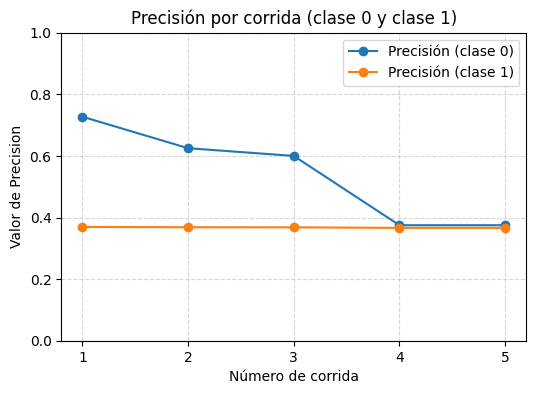

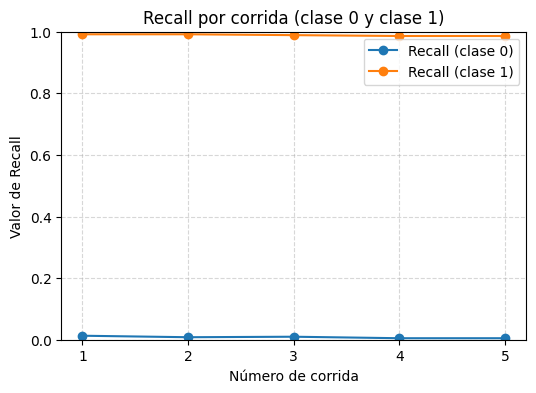

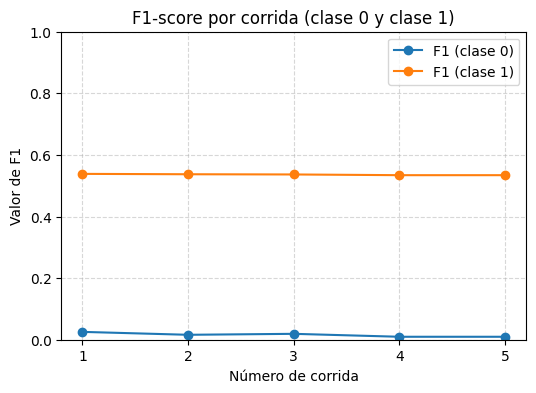

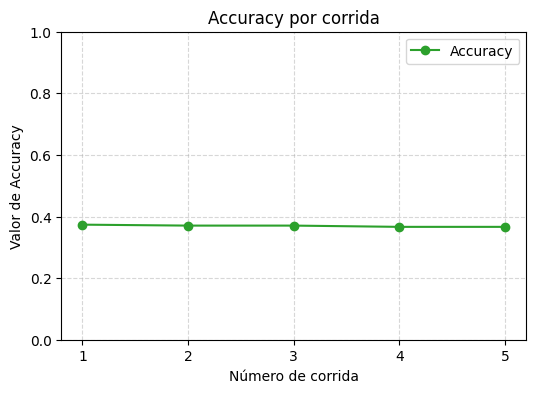

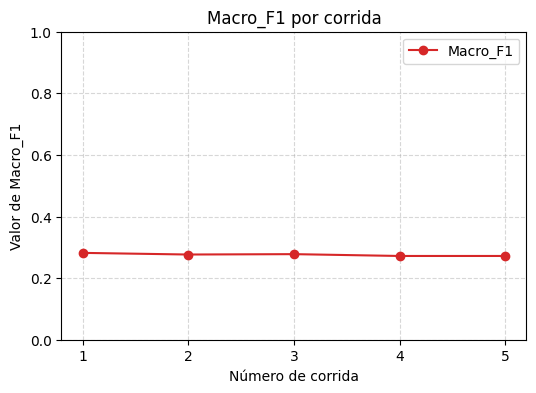

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1) Supongamos que ya tienes tu DataFrame `df_resultados_long`
# --------------------------------------------------------

# Si tu DataFrame se llama de otro modo, cámbialo a continuación:
df = df_resultados

# --------------------------------------------------------
# 2) Definimos los estilos básicos de los gráficos
# --------------------------------------------------------
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["lines.marker"]   = 'o'
plt.rcParams["lines.linestyle"] = '-'
plt.rcParams["axes.grid"]      = True
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["grid.alpha"]     = 0.5

# Estas dos listas las usamos para “sacar” los valores de cada corrida:
runs = sorted(df["run"].unique())

# Colores fijos (uno para cada clase)
color_clase = {0: "#1f77b4", 1: "#ff7f0e"}

# --------------------------------------------------------
# 3) Gráfico de PRECISIÓN (ambas clases en el mismo plot)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    # Tomamos sólo las filas de esa clase, ordenadas por corrida
    subset = df[df["clase"] == clase].sort_values("run")
    valores = subset["precision"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Precisión (clase {clase})")

plt.title("Precisión por corrida (clase 0 y clase 1)")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de Precision")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()


# --------------------------------------------------------
# 4) Gráfico de RECALL (ambas clases en el mismo plot)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run")
    valores = subset["recall"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Recall (clase {clase})")

plt.title("Recall por corrida (clase 0 y clase 1)")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de Recall")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()


# --------------------------------------------------------
# 5) Gráfico de F1-SCORE (ambas clases en el mismo plot)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run")
    valores = subset["f1"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"F1 (clase {clase})")

plt.title("F1-score por corrida (clase 0 y clase 1)")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()


# --------------------------------------------------------
# 7) Gráficos de métricas globales (una sola línea con un valor por corrida)
# --------------------------------------------------------
# 7.1) ACCURACY
plt.figure()
acc_por_run = df.groupby("run")["accuracy"].first().reset_index()
plt.plot(acc_por_run["run"], acc_por_run["accuracy"], color="#2ca02c", label="Accuracy")
plt.title("Accuracy por corrida")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de Accuracy")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()

# 7.2) MACRO_F1
plt.figure()
macro_por_run = df.groupby("run")["macro_f1"].first().reset_index()
plt.plot(macro_por_run["run"], macro_por_run["macro_f1"], color="#d62728", label="Macro_F1")
plt.title("Macro_F1 por corrida")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de Macro_F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()
